# 科学计算: 插值部分作业

Author: LZK

Date: 2022-4-2

利用[-5,5]内的等分点，作为插值结点，形成$\frac{1}{1+x^{2\:}} $的n次多项式插值

任务：

1. 利用相同的等分点，构造Lagrange插值法、Newton插值法、三次样条函数插值
2. 利用同样次数的切比雪夫多项式的根，作插值结点，构造插值多项式；
3. 利用同样次数的勒让德多项式的根，作插值结点，构造插值多项式。

比较插值结果。

In [1]:
import numpy as np
import scipy
import scipy.linalg
import scipy.special
import scipy.optimize
import pandas as pd
import matplotlib.pyplot as plt

import warnings

### 工具类与函数库

In [2]:
# Lagrange Interpolation
class Lagrange:

    def __init__(self, x0, y0):
        assert len(x0) == len(y0)
        self.x0 = np.array(x0)
        self.y0 = np.array(y0)
        self.scale = len(self.x0)
    
    
    def __call__(self, x):
        x = np.array(x)
        summ = np.zeros_like(x)
        for i in range(self.scale):
            summ += self.y0[i] * self.base_func(x, i)
        return summ


    def base_func(self, x, i):
        prod = np.ones_like(x)
        for k in range(self.scale):
            if k != i:
                prod *= (x - self.x0[k]) / (self.x0[i] - self.x0[k])
        return prod

In [3]:
# Newton Interpolation
class Newton:
    
    def __init__(self, x0, y0):
        assert len(x0) == len(y0)
        self.x0 = np.array(x0)
        self.y0 = np.array(y0)
        self.scale = len(x0)
        self.quotient = np.zeros(shape=(self.scale-1, self.scale-1))
        self.marker = 0
    
    
    def __call__(self, x):
        self._quotient()
        summ = np.ones(len(x)) * self.y0[0]
        for i in range(self.scale-1):
            item = self.quotient[i, 0]
            for k in range(i+1):
                item *= (x - self.x0[k])
            summ += item
        return summ


    def _quotient(self):
        # @TODO Breaking point remenber & re-run
        for i in range(self.scale-1):
            for j in range(self.scale-1-i):
                if i == 0:
                    self.quotient[i, j] = (self.y0[j+1] - self.y0[j]) / (self.x0[j+1] - self.x0[j])
                    continue
                self.quotient[i, j] = (self.quotient[i-1, j+1] - self.quotient[i-1, j]) / (self.x0[j+i+1] - self.x0[j])
        self.marker = self.scale


    def append(self, x, y):
        assert len(x) == len(y)
        self.x0 = np.append(self.x0, x)
        self.y0 = np.append(self.y0, y)
        self.scale = len(self.x0)
        self._quotient()

In [4]:
# Cubic-Spline Interpolation
class Spline:

    def __init__(self, x0, y0):
        # Check
        assert len(x0) == len(y0)
        for i in range(len(x0) - 1):
            if x0[i] >= x0[i+1]:
                raise ValueError("Input x0 monotonically increasing.")

        # ----- Initialize -----
        self.x0 = np.array(x0)
        self.y0 = np.array(y0)
        self.scale = len(self.x0)

        self.a = np.zeros(self.scale)
        self.b = np.zeros(self.scale)
        self.c = np.zeros(self.scale)
        self.d = np.zeros(self.scale)

        # ----- Generate Spline -----
        delta_x = np.zeros(self.scale)
        delta_y = np.zeros(self.scale)

        for i in range(self.scale-1):
            self.a[i] = self.y0[i]
            delta_x[i] = self.x0[i+1] - self.x0[i]
            delta_y[i] = self.y0[i+1] - self.y0[i]
        
        # Generate the c-matrix
        matrix = np.zeros(shape=(self.scale, self.scale))
        vector = np.zeros(self.scale)
        for i in range(self.scale):
            if i == 0 or i == self.scale-1:
                matrix[i, i] = 1.0
                vector[i] = 0.0
                continue
            matrix[i, i-1] = delta_x[i-1]
            matrix[i, i] = 2 * delta_x[i-1] + delta_x[i]
            matrix[i, i+1] = delta_x[i]
            vector[i] = 3 * (delta_y[i]/delta_x[i] - delta_y[i-1]/delta_x[i-1])
        
        # Solve the c-matrix equation
        self.c = scipy.linalg.solve(matrix, vector)

        # Generate b & d
        for i in range(self.scale-1):
            self.b[i] = delta_y[i]/delta_x[i] - delta_x[i] * (2*self.c[i] + self.c[i+1]) / 3
            self.d[i] = (self.c[i+1] - self.c[i]) / (3 * delta_x[i])
    
    
    def __call__(self, x):
        x = np.array(x)
        y = np.zeros_like(x)

        # Check
        if np.any(x < self.x0[0]) or np.any(x > self.x0[-1]):
            warnings.warn("Input x out of range of x0.")
        
        for i in range(len(x)):

            # x equal to x0
            if np.any(self.x0 == x[i]):
                index = np.where(self.x0 == x[i])[0].item()
                y[i] = self.y0[index]
                continue
            
            # x out of range
            if x[i] < self.x0[0]:
                index = 0
                y[i] = self.a[index] + self.b[index]*(x[i] - self.x0[index]) + self.c[index]*(x[i] - self.x0[index])**2 + self.d[index]*(x[i] - self.x0[index])**3
                continue
            if x[i] > self.x0[-1]:
                index = self.scale - 1
                y[i] = self.a[index] + self.b[index]*(x[i] - self.x0[index]) + self.c[index]*(x[i] - self.x0[index])**2 + self.d[index]*(x[i] - self.x0[index])**3
                continue
            
            # x of normal type
            for k in range(self.scale - 1):
                if (self.x0[k] < x[i]) and (x[i] < self.x0[k+1]):
                    index = k
                    y[i] = self.a[index] + self.b[index]*(x[i] - self.x0[index]) + self.c[index]*(x[i] - self.x0[index])**2 + self.d[index]*(x[i] - self.x0[index])**3
                    break
        
        return y

In [5]:
# Chebyshev Roots
class Chebyshev:
    
    def __init__(self, a, b):
        """
        Generate Chebyshev interpolation x0 in interval[a,b]
        a: left endpoint of interval
        b: right endpoint of interval
        """
        assert a < b
        self.a = a
        self.b = b
    
    def __call__(self, n):
        """
        Generate n Chebyshev interpolation points
        n: int, number of Chebyshev x0
        """
        i = np.arange(1, n+1)
        return np.sort((self.b + self.a)/2 + (self.b - self.a)/2 * np.cos((2*i-1)*np.pi/(2*n)))

There is no expression of Legendre roots, so we solve them from Legendre Polynomials.

In [6]:
def legendre(n, x):
    if n == 0:
        return 1
    if n == 1:
        return x
    return (2*n-1)/n * x * legendre(n-1, x) - (n-1)/n * legendre(n-2, x)

In [7]:
scipy.optimize.fsolve(lambda x: legendre(2, x), x0=np.array([0.1, -0.7]))

array([ 0.57735027, -0.57735027])

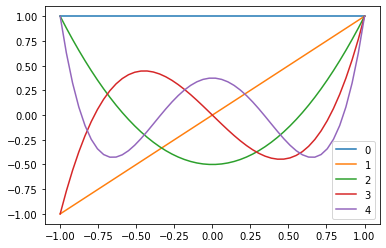

In [8]:
x = np.linspace(-1, 1, 50)
for n in range(5):
    y = []
    for xi in x:
        y.append(legendre(n, xi))
    plt.plot(x, y, label=str(n))
plt.legend()

Finding roots using scipy.optimize.fsolve needs a good initial guess, which is hard actually.

To improve the initial guess, we calculate the function on many locations to avoid ignoring. It is like the first step of bi-search.

In [9]:
class FindRoot:

    def __init__(self):
        pass

    def findRoot(self, func, n, a, b):
        """
        func: the function to solve
        n: number of roots
        """
        guess = np.linspace(a, b, 100*n)
        func_isPositive = (np.array(func(guess)) > 0)

        last = None
        roots = []
        for x, isPositive in zip(guess, func_isPositive):
            if last is None:
                last = isPositive
                continue
            if last is not isPositive:
                roots.append(x)
                last = isPositive
        
        if len(roots) < n:
            warnings.warn("FindRoot: Roots may be ignored.")
        
        return scipy.optimize.fsolve(func, x0=roots)

In [10]:
# Legendre Roots
class Legendre(FindRoot):
    
    def __init__(self, a, b):
        super().__init__()
        assert a < b
        self.a = a
        self.b = b
    
    def __call__(self, n):
        # scipy.optimize.fsolve(lambda x: scipy.special.lpn(n, x)[0][-1], x0=0)

        # guess = -1 + np.arange(1, n+1) * 2 / (n+1) # Fail when n > 3 !
        # roots = scipy.optimize.fsolve(lambda x: self._legendre(n, x), x0=guess)
        
        roots = self.findRoot(lambda x: self._legendre(n, x), n, -1.0, 1.0)
        for i in range(len(roots)-1):
            for j in range(i+1, len(roots)):
                if abs(roots[j] - roots[i]) < 1e-4:
                    warnings.warn("Legendre: Roots may be ignored.")
        return (self.b+self.a)/2 + (self.b-self.a)/2 * roots
    
    def _legendre(self, n, x):
        if n == 0:
            return 1
        if n == 1:
            return x
        return (2*n-1)/n * x * self._legendre(n-1, x) - (n-1)/n * self._legendre(n-2, x)

In [11]:
lg = Legendre(-1, 1)
lg(4)

array([-0.86113631, -0.33998104,  0.33998104,  0.86113631])

### 对比分析

In [25]:
# Main Analysis
def mainAnalysis(x0, info=True, savefig=False):

    def f(x):
        return 1 / (1 + x**2)
    
    # Base points
    y0 = f(x0)

    # Interpolation
    polynomialLagrange = Lagrange(x0, y0)
    polynomialNewton = Newton(x0, y0)
    polynomialSpline = Spline(x0, y0)

    # Sample
    x = np.linspace(*interval, 200)
    yReal = f(x)
    yLagrange = polynomialLagrange(x)
    yNewton = polynomialNewton(x)
    ySpline = polynomialSpline(x)

    # Find the largest error between Interpolation Polynomials & f(x)
    errorLagrange = [0, yLagrange[0] - yReal[0]]
    errorNewton = [0, yNewton[0] - yReal[0]]
    errorSpline = [0, ySpline[0] - yReal[0]]
    for i in range(1, len(x)):
        if (yLagrange[i] - yReal[i]) > errorLagrange[1]:
            errorLagrange[0] = i
            errorLagrange[1] = yLagrange[i] - yReal[i]
        if (yNewton[i] - yReal[i]) > errorNewton[1]:
            errorNewton[0] = i
            errorNewton[1] = yNewton[i] - yReal[i]
        if (ySpline[i] - yReal[i]) > errorSpline[1]:
            errorSpline[0] = i
            errorSpline[1] = ySpline[i] - yReal[i]

    if info:
        print("Lagrange: {:.2f}".format(yLagrange[errorLagrange[0]]))
        print("Newton: {:.2f}".format(yNewton[errorNewton[0]]))
        print("Spline: {:.2f}".format(ySpline[errorSpline[0]]))

    if info:
        plt.plot(x, yReal, label='f(x)')
        plt.plot(x, yLagrange, label='Lagrange')
        plt.plot(x, yNewton, label='Newton')
        plt.plot(x, ySpline, label='Cubic Spline')

        # plt.axvline(x=x[errorLagrange[0]], linestyle='dashed')
        # plt.axvline(x=x[errorNewton[0]], linestyle='dashed')
        # plt.axvline(x=x[errorSpline[0]], linestyle='dashed')
        # plt.text(x=x[errorLagrange[0]], y=1.1*yLagrange[errorLagrange[0]], s="Lagrange{:.2f}".format(yLagrange[errorLagrange[0]]))
        # plt.text(x=x[errorNewton[0]], y=1.1*yNewton[errorNewton[0]], s="Newton{:.2f}".format(yNewton[errorNewton[0]]))
        # plt.text(x=x[errorSpline[0]], y=1.1*ySpline[errorSpline[0]], s="Spline{:.2f}".format(ySpline[errorSpline[0]]))

        plt.title('Comparison of Interpolation on {}-order'.format(n-1))
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
    if savefig:
        plt.savefig('Interpolations.svg', format='svg')

    return errorLagrange[1], errorNewton[1],errorSpline[1]

<ipython-input-4-4efc9abdf776>:58: UserWarning: Input x out of range of x0.
  warnings.warn("Input x out of range of x0.")
<ipython-input-4-4efc9abdf776>:58: UserWarning: Input x out of range of x0.
  warnings.warn("Input x out of range of x0.")
<ipython-input-4-4efc9abdf776>:58: UserWarning: Input x out of range of x0.
  warnings.warn("Input x out of range of x0.")
<ipython-input-4-4efc9abdf776>:58: UserWarning: Input x out of range of x0.
  warnings.warn("Input x out of range of x0.")
<ipython-input-4-4efc9abdf776>:58: UserWarning: Input x out of range of x0.
  warnings.warn("Input x out of range of x0.")
<ipython-input-4-4efc9abdf776>:58: UserWarning: Input x out of range of x0.
  warnings.warn("Input x out of range of x0.")


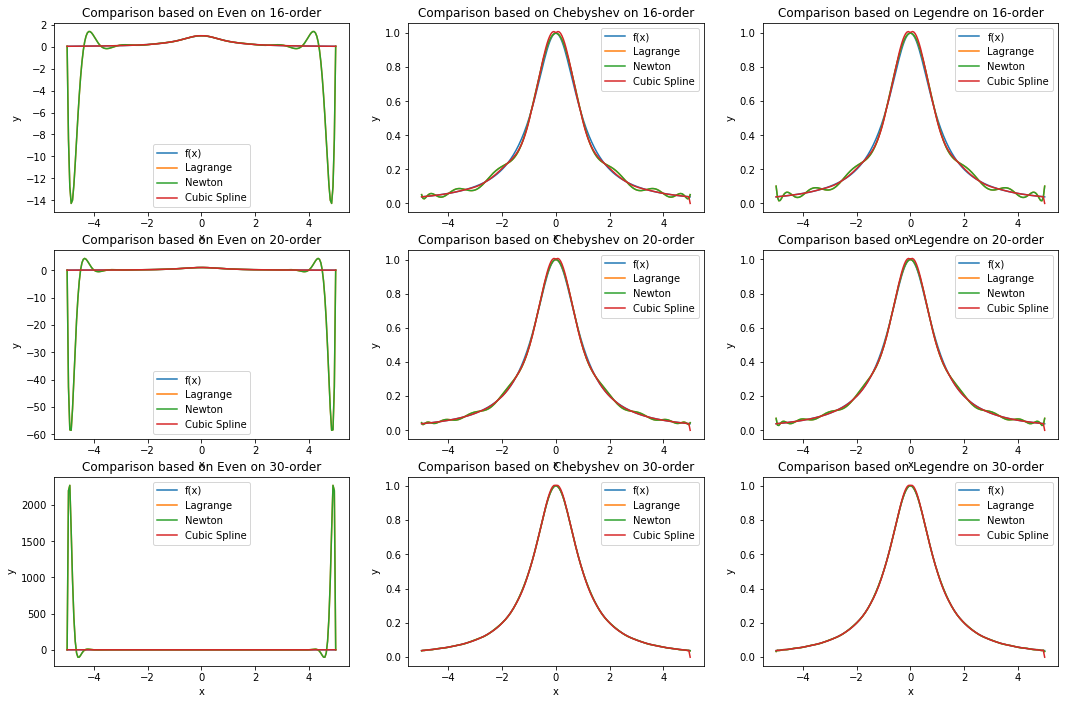

In [21]:
# Generate points
# order = (9, 12)
order = [17, 21, 31]
cnt = 0
plt.figure(figsize=(18, 16))

# for n in range(*order):
for n in order:
    numPoints = n
    interval = (-5.0, 5.0)
    pointEven = np.linspace(*interval, numPoints)
    pointChebyshev = Chebyshev(*interval)(numPoints)
    pointLegendre = Legendre(*interval)(numPoints)

    # print("Even: ", pointEven)
    # print("Chebyshev:", pointChebyshev)
    # print("Legendre:", pointLegendre)

    # Run analysis
    def f(x):
        return 1 / (1 + x**2)
    
    for name, point in zip(['Even', 'Chebyshev', 'Legendre'], [pointEven, pointChebyshev, pointLegendre]):
        # Base points
        y0 = f(point)

        # Interpolation
        polynomialLagrange = Lagrange(point, y0)
        polynomialNewton = Newton(point, y0)
        polynomialSpline = Spline(point, y0)

        # Sample
        x = np.linspace(*interval, 200)
        yReal = f(x)
        yLagrange = polynomialLagrange(x)
        yNewton = polynomialNewton(x)
        ySpline = polynomialSpline(x)

        # Find the largest error between Interpolation Polynomials & f(x)
        errorLagrange = [0, yLagrange[0] - yReal[0]]
        errorNewton = [0, yNewton[0] - yReal[0]]
        errorSpline = [0, ySpline[0] - yReal[0]]
        for i in range(1, len(x)):
            if (yLagrange[i] - yReal[i]) > errorLagrange[1]:
                errorLagrange[0] = i
                errorLagrange[1] = yLagrange[i] - yReal[i]
            if (yNewton[i] - yReal[i]) > errorNewton[1]:
                errorNewton[0] = i
                errorNewton[1] = yNewton[i] - yReal[i]
            if (ySpline[i] - yReal[i]) > errorSpline[1]:
                errorSpline[0] = i
                errorSpline[1] = ySpline[i] - yReal[i]

        # print("Lagrange: {:.2f}".format(yLagrange[errorLagrange[0]]))
        # print("Newton: {:.2f}".format(yNewton[errorNewton[0]]))
        # print("Spline: {:.2f}".format(ySpline[errorSpline[0]]))

        row = order[1] - order[0]
        column = 3
        cnt += 1
        plt.subplot(100*row + 10*column + cnt)
        plt.plot(x, yReal, label='f(x)')
        plt.plot(x, yLagrange, label='Lagrange')
        plt.plot(x, yNewton, label='Newton')
        plt.plot(x, ySpline, label='Cubic Spline')

        # plt.axvline(x=x[errorLagrange[0]], linestyle='dashed')
        # plt.axvline(x=x[errorNewton[0]], linestyle='dashed')
        # plt.axvline(x=x[errorSpline[0]], linestyle='dashed')
        # plt.text(x=x[errorLagrange[0]], y=1.1*yLagrange[errorLagrange[0]], s="Lagrange{:.2f}".format(yLagrange[errorLagrange[0]]))
        # plt.text(x=x[errorNewton[0]], y=1.1*yNewton[errorNewton[0]], s="Newton{:.2f}".format(yNewton[errorNewton[0]]))
        # plt.text(x=x[errorSpline[0]], y=1.1*ySpline[errorSpline[0]], s="Spline{:.2f}".format(ySpline[errorSpline[0]]))

        plt.title('Comparison based on {} on {}-order'.format(name, n-1))
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        if True:
            plt.savefig('Interpolations{}-{}.svg'.format(*order), format='svg')

最后统计三种插值多项式、三种插值节点在各阶(节点数)上的插值误差

In [26]:
points = {}
table = []

for numPoints in list(range(6, 12))+[17, 21, 31]:
    interval = (-5.0, 5.0)
    points['Even'] = np.linspace(*interval, numPoints)
    points['Chebyshev'] = Chebyshev(*interval)(numPoints)
    points['Legendre'] = Legendre(*interval)(numPoints)

    for name, point in points.items():
        table.append([numPoints-1, name, *mainAnalysis(point, info=False)])

df = pd.DataFrame(table, columns=['order', 'point', 'Lagrange', 'Newton', 'Spline'])

<ipython-input-4-4efc9abdf776>:58: UserWarning: Input x out of range of x0.
  warnings.warn("Input x out of range of x0.")


In [27]:
df

,order,point,Lagrange,Newton,Spline
0,5,Even,0.127367,0.127367,0.106535
1,5,Chebyshev,0.088044,0.088044,0.075368
2,5,Legendre,0.096402,0.096402,0.081820
3,6,Even,0.616546,0.616546,0.165682
4,6,Chebyshev,0.264226,0.264226,0.269004
5,6,Legendre,0.241330,0.241330,0.241020
6,7,Even,0.171492,0.171492,0.092366
7,7,Chebyshev,0.094766,0.094766,0.088854
8,7,Legendre,0.097219,0.097219,0.089981
9,8,Even,0.246241,0.246241,0.084899


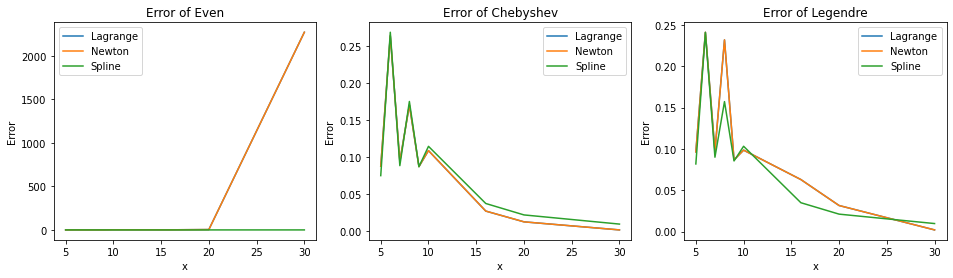

In [29]:
plt.figure(figsize=(16, 4))
for i, point in enumerate(points.keys()):
    subfig = plt.subplot(131+i)
    choice = df[df['point'] == point]
    for poly in ['Lagrange', 'Newton', 'Spline']:
        plt.plot(choice['order'], choice[poly], label=poly)
    plt.title('Error of {}'.format(point))
    plt.xlabel('x')
    plt.ylabel('Error')
    plt.legend()
    plt.savefig('error.svg', format='svg')